In [2]:
%load_ext autoreload
%autoreload 2
!pip install kornia==0.6.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
ERROR: Operation cancelled by user


In [3]:
!pip install kornia_moons

ERROR: Operation cancelled by user


In [4]:
!pip install pycolmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 59.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 397, in resolve
    self._

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Renamed 101 files in /content/drive/MyDrive/Loftr/dirname


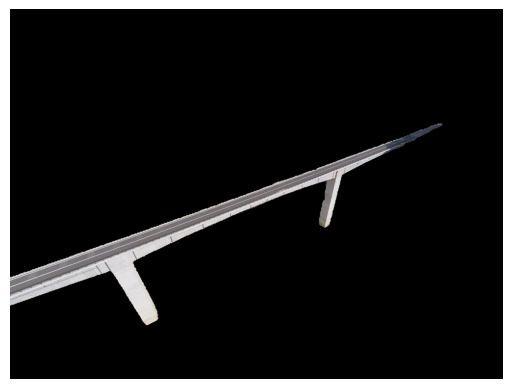

In [8]:
from google.colab import drive
import os
import re
import cv2
import matplotlib.pyplot as plt


# Mount Google Drive
drive.mount('/content/drive')

def rename_images_in_directory(directory_path, new_name_pattern):
    # List all files in the directory
    files = os.listdir(directory_path)

    # Filter out non-image files (basic filtering, adjust as needed)
    image_files = [f for f in files if re.search(r'\.(jpg|jpeg|png|gif|bmp)$', f, re.IGNORECASE)]

    # Rename each image file
    for index, file_name in enumerate(image_files):
        # Construct the new file name
        new_file_name = new_name_pattern.format(index)

        # Construct full file paths
        old_file_path = os.path.join(directory_path, file_name)
        new_file_path = os.path.join(directory_path, new_file_name)

        # Rename the file
        os.rename(old_file_path, new_file_path)

    print(f"Renamed {len(image_files)} files in {directory_path}")



# Example: Change the path to your directory
dirname = '/content/drive/MyDrive/Loftr/dirname'

# Example: New name pattern (e.g., "image_0.jpg", "image_1.jpg", ...)
new_name_pattern = "{}.jpg"

# Call the function
rename_images_in_directory(dirname, new_name_pattern)

# List image filenames and display the first image
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axis
plt.show()


In [5]:
import os
import cv2
import h5py
import torch
import kornia as K
import kornia.feature as KF
from collections import defaultdict
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import fastprogress
import numpy as np
from tqdm import tqdm as progress_bar
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def load_torch_image(fname, device=torch.device('cuda')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cuda')

ModuleNotFoundError: No module named 'kornia'

## Download example data

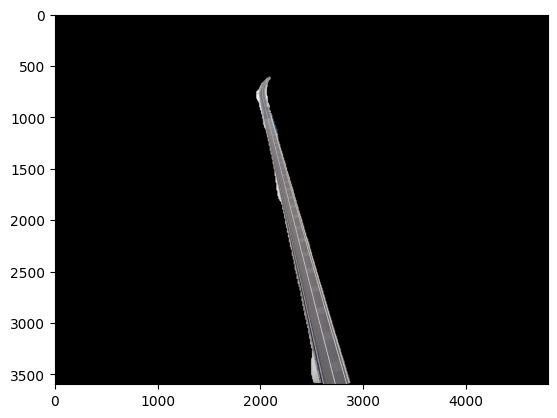

In [ ]:
dirname = os.path.join('/content/drive/MyDrive/Loftr/dirname')
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

## LoFTR Matching

In [ ]:
def get_unique_idxs(A, dim=1):
    unique, idx, counts = torch.unique(A, dim=dim, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0], device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def batch_process(index_pairs, batch_size):
    """Divise les paires d'index en lots."""
    for i in range(0, len(index_pairs), batch_size):
        yield index_pairs[i:i + batch_size]

# min_matches=100, resize_to_ = (1536,1024)
# try this : (2048, 1536)
def match_features(img_fnames: list,
                   index_pairs: list,
                   feature_dir: str = '/content/drive/MyDrive/Loftr/featureout_loftr',
                   device: torch.device = torch.device('cuda'),
                   min_matches=150, resize_to_ = (1920, 1280),
                   batch_size: int = 100):
    """Perform feature matching in pairs using the LoFTR model."""

    matcher = KF.LoFTR(pretrained='outdoor').to(device).eval()
    matcher = matcher.half()  # Convert model to half-precision

    # Create the output directory if it does not exist
    os.makedirs(feature_dir, exist_ok=True)

    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='w') as f_match:
        for batch in batch_process(index_pairs, batch_size):
            for pair_idx in progress_bar(batch):
                torch.cuda.empty_cache()  # Free GPU memory
                idx1, idx2 = pair_idx
                fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
                key1, key2 = os.path.basename(fname1), os.path.basename(fname2)

                # Load img1 and img2 and resize
                timg1 = K.color.rgb_to_grayscale(load_torch_image(fname1, device=device))
                H1, W1 = timg1.shape[2:]
                resize_to1 = (resize_to_[1], resize_to_[0]) if H1 < W1 else resize_to_
                timg_resized1 = K.geometry.resize(timg1, resize_to1, antialias=True)
                h1, w1 = timg_resized1.shape[2:]

                timg2 = K.color.rgb_to_grayscale(load_torch_image(fname2, device=device))
                H2, W2 = timg2.shape[2:]
                resize_to2 = (resize_to_[1], resize_to_[0]) if H2 < W2 else resize_to_
                timg_resized2 = K.geometry.resize(timg2, resize_to2, antialias=True)
                h2, w2 = timg_resized2.shape[2:]

                with torch.inference_mode():
                    input_dict = {"image0": timg_resized1.half(), "image1": timg_resized2.half()}  # Use half precision
                    correspondences = matcher(input_dict)

                mkpts0 = correspondences['keypoints0'].cpu().numpy()
                mkpts1 = correspondences['keypoints1'].cpu().numpy()

                mkpts0[:, 0] *= float(W1) / float(w1)
                mkpts0[:, 1] *= float(H1) / float(h1)

                mkpts1[:, 0] *= float(W2) / float(w2)
                mkpts1[:, 1] *= float(H2) / float(h2)

                n_matches = len(mkpts1)
                group = f_match.require_group(key1)
                if n_matches >= min_matches:
                    group.create_dataset(key2, data=np.concatenate([mkpts0, mkpts1], axis=1))

    # Find unique LoFTR pixels and group them
    kpts = defaultdict(list)
    match_indexes = defaultdict(dict)
    total_kpts = defaultdict(int)

    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='r') as f_match:
        for k1 in f_match.keys():
            group = f_match[k1]
            for k2 in group.keys():
                matches = group[k2][...]
                total_kpts[k1]
                kpts[k1].append(matches[:, :2])
                kpts[k2].append(matches[:, 2:])
                current_match = torch.arange(len(matches)).reshape(-1, 1).repeat(1, 2)
                current_match[:, 0] += total_kpts[k1]
                current_match[:, 1] += total_kpts[k2]
                total_kpts[k1] += len(matches)
                total_kpts[k2] += len(matches)
                match_indexes[k1][k2] = current_match

    for k in kpts.keys():
        kpts[k] = np.round(np.concatenate(kpts[k], axis=0))

    unique_kpts = {}
    unique_match_idxs = {}
    out_match = defaultdict(dict)

    for k in kpts.keys():
        uniq_kps, uniq_reverse_idxs = torch.unique(torch.from_numpy(kpts[k]), dim=0, return_inverse=True)
        unique_match_idxs[k] = uniq_reverse_idxs
        unique_kpts[k] = uniq_kps.numpy()

    for k1, group in match_indexes.items():
        for k2, m in group.items():
            m2 = deepcopy(m)
            m2[:, 0] = unique_match_idxs[k1][m2[:, 0]]
            m2[:, 1] = unique_match_idxs[k2][m2[:, 1]]
            mkpts = np.concatenate([unique_kpts[k1][m2[:, 0]], unique_kpts[k2][m2[:, 1]]], axis=1)
            unique_idxs_current = get_unique_idxs(torch.from_numpy(mkpts), dim=0)
            m2_semiclean = m2[unique_idxs_current]
            unique_idxs_current1 = get_unique_idxs(m2_semiclean[:, 0], dim=0)
            m2_semiclean = m2_semiclean[unique_idxs_current1]
            unique_idxs_current2 = get_unique_idxs(m2_semiclean[:, 1], dim=0)
            m2_semiclean2 = m2_semiclean[unique_idxs_current2]
            out_match[k1][k2] = m2_semiclean2.numpy()

    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp:
        for k, kpts1 in unique_kpts.items():
            f_kp[k] = kpts1

    with h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for k1, gr in out_match.items():
            group = f_match.require_group(k1)
            for k2, match in gr.items():
                group[k2] = match

    return

In [ ]:
# Apparier toutes les images entre elles
index_pairs = [(i, j) for i in range(len(img_fnames)) for j in range(i+1, len(img_fnames))]

In [ ]:
# Create the directory if it doesn't exist
if not os.path.exists('/content/drive/MyDrive/Loftr/featureout_loftr'):
    os.makedirs('/content/drive/MyDrive/Loftr/featureout_loftr')

feature_dir = '/content/drive/MyDrive/Loftr/featureout_loftr'

In [ ]:
print(len(index_pairs))
match_features(img_fnames, index_pairs)

5253


Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt
100%|██████████| 44.2M/44.2M [00:02<00:00, 19.6MB/s]
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 53/53 [01:52<00:00,  2.12s/it]
